In [1]:
import os
from pathlib import Path
from typing import Callable
import warnings

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from segregation.aspatial import MinMax, Dissim
import rasterio as rio
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

data_dir = Path('../data')


In [2]:
def get_xy(
        geodf: gpd.GeoDataFrame,
        geometry_col: str = None,
) -> gpd.GeoDataFrame:

    if not geometry_col:
        geometry_col = geodf.geometry.name

    if geodf[geometry_col].geom_type[0] == 'Point':
        geodf['x'] = geodf[geometry_col].apply(lambda geom: geom.x)
        geodf['y'] = geodf[geometry_col].apply(lambda geom: geom.y)
    else:
        geodf['x'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[0]))
        geodf['y'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[1]))
    return geodf


def kernel_density_surface(
        data: gpd.GeoDataFrame,
        group: str,
        bandwidth,
        cell_size,
        kernel_function: Callable,
):
    pop = get_xy(data)
    pad = bandwidth * 2

    minx, miny, maxx, maxy = pop.geometry.total_bounds

    minx -= pad
    miny -= pad
    maxx += pad
    maxy += pad

    x = np.arange(minx, maxx, cell_size)
    y = np.arange(miny, maxy, cell_size)

    X, Y = np.meshgrid(x, y)

    xy = np.vstack([Y.ravel(), X.ravel()]).T

    U = cdist(xy, pop[['y', 'x']].values, metric='euclidean')
    W = kernel_function(U, bandwidth=bandwidth)

    density = (W * pop[group].values).sum(axis=1).reshape(X.shape)

    geotiff_meta = {
        'driver': 'GTiff',
        'count': 1,
        'dtype': 'float64',
        'width': len(x),
        'height': len(y),
        'crs': data.crs,
        'transform': rio.transform.from_bounds(
            west=minx,
            east=maxx,
            north=maxy,
            south=miny,
            width=len(x),
            height=len(y),
        )
    }

    return density[::-1, ], geotiff_meta


def point_value(point: Point, raster: rio.DatasetReader):
    x, y = point.x, point.y
    r, c = raster.index(x, y)
    value = raster.read(1)[r, c]

    return value


In [3]:
def split_plots(
        geodataframe: gpd.GeoDataFrame,
        target_col: str,
        separator: str = ',',
) -> gpd.GeoDataFrame:

    new_geodataframe = gpd.GeoDataFrame(columns=geodataframe.columns)

    for _, row in geodataframe.iterrows():
        plots = str(row[target_col]).split(separator)

        if len(plots) < 2:
            new_geodataframe = new_geodataframe.append(row)
            continue

        for plot in plots:
            new_row = row
            new_row[target_col] = plot
            new_geodataframe = new_geodataframe.append(new_row)

    assert len(new_geodataframe.index) == len(list(pd.core.common.flatten(
        [
            str(w).split(separator)
            for w
            in geodataframe[target_col]
        ]))), 'splitting failed'

    return new_geodataframe.reindex()

In [4]:
warnings.simplefilter(action='ignore', category=FutureWarning)

district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
institutions = pd.read_csv(data_dir / 'institutions.csv', dtype={'district': str, 'plot_number': str})

location_data = gpd.read_file(data_dir / 'raw' / 'plots_1878.shp').to_crs(epsg=3067)
location_data = split_plots(location_data, target_col='NUMBER')
location_data['district'] = [district_codes[int(d)] for d in location_data['DISTRICT']]
location_data['plot_number'] = [str(i) for i in location_data['NUMBER']]
location_data = location_data.set_index(['district', 'plot_number'])
city = gpd.read_file(data_dir / 'raw' / 'city_1846.shp').to_crs(epsg=3067)
location_data = location_data.loc[~location_data.geometry.within(city.geometry[0]).index.duplicated()]
location_data = location_data.loc[location_data.geometry.within(city.geometry[0])]

district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}

lutheran_density = rio.open('../data/processed/lutheran_density_1880_250_m.tif')
orthodox_density = rio.open('../data/processed/orthodox_density_1880_250_m.tif')
total_density = rio.open('../data/processed/total_density_1880_250_m.tif')
location_data['lutheran_density'] = location_data.geometry.apply(point_value, raster=lutheran_density).round(4)
location_data['orthodox_density'] = location_data.geometry.apply(point_value, raster=orthodox_density).round(4)
location_data['total_density'] = location_data.geometry.apply(point_value, raster=total_density).round(4)
location_data.drop(columns=['DISTRICT', 'NUMBER'], inplace=True)


In [5]:
income = pd.read_csv(data_dir / 'interim' / 'income_tax_record_1880.csv', index_col=0)
income.set_index(['district', 'plot_number'], drop=True, inplace=True)
income['total_income'] = income.loc[:,
                         ['estate_income', 'business_income', 'salary_pension_income']
                         ].sum(axis=1)
income

estate_income  business_income  \
district      plot_number                                   
Valli         1                      0.0              0.0   
              2                     15.0              0.0   
              2                      0.0              0.0   
              2                      0.0              0.0   
              2                      0.0              0.0   
...                                  ...              ...   
Sorvalinsaari 18                     0.0              0.0   
              18                     0.0              0.0   
              19                     0.0              0.0   
              19                     0.0              0.0   
              19                     0.0              0.0   

                           salary_pension_income  total_income  
district      plot_number                                       
Valli         1                              3.0           3.0  
              2                             25.0          40.0  
              2                              1.0           1.0  
              2                              1.0           1.0  
              2                             40.0          40.0  
...                                          ...           ...  
Sorvalinsaari 18                             1.0           1.0  
              18                             1.0           1.0  
              19                             1.0           1.0  
              19                             1.0           1.0  
              19                             1.0           1.0  

[3336 rows x 4 columns]

In [6]:
income.describe()

,estate_income,business_income,salary_pension_income,total_income
count,3336.000000,3336.000000,3336.000000,3336.000000
mean,0.826739,1.786271,2.419964,5.032974
std,3.067548,16.865182,6.133464,18.756135
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000
50%,0.000000,0.000000,1.000000,1.000000
75%,0.000000,0.000000,2.000000,3.000000
max,40.000000,554.000000,115.000000,562.000000


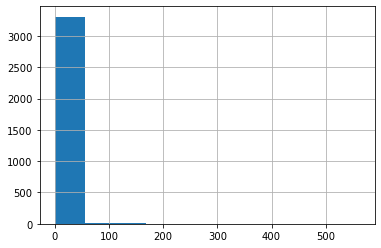

In [7]:
income.total_income.hist()
plt.show()

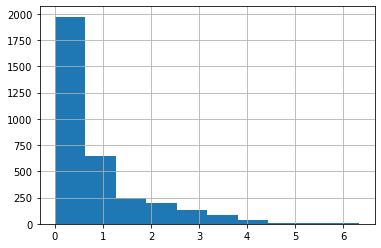

In [8]:
income['total_income_log'] = income.total_income.apply(lambda x: np.log(x) if x > 0 else 0).round(4)
income.total_income_log.hist()
plt.show()

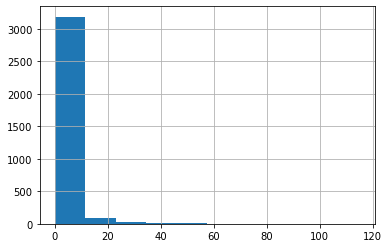

In [9]:
income.salary_pension_income.hist()
plt.show()

In [10]:
data = location_data.join(income)
data.to_file('../data/interim/spatial_income_1880.shp')